In [1]:
import pandas as pd
df = pd.read_csv('rank.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368999 entries, 0 to 368998
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   time                                 368999 non-null  float64
 1   source                               368999 non-null  int64  
 2   destination                          368999 non-null  int64  
 3   length                               368999 non-null  float64
 4   info                                 368999 non-null  float64
 5   transmission_rate_per_1000_ms        368999 non-null  float64
 6   reception_rate_per_1000_ms           368999 non-null  float64
 7   transmission_average_per_sec         368999 non-null  float64
 8   reception_average_per_sec            368999 non-null  float64
 9   transmission_count_per_sec           368999 non-null  float64
 10  reception_count_per_sec              368999 non-null  float64
 11  transmission_

In [2]:
df.head()

,time,source,destination,length,info,transmission_rate_per_1000_ms,reception_rate_per_1000_ms,transmission_average_per_sec,reception_average_per_sec,transmission_count_per_sec,reception_count_per_sec,transmission_total_duration_per_sec,reception_total_duration_per_sec,dao,dis,dio,category,label
0,0.015,39,9999,0.0,1.0,0.000000,0.668873,0.000000,0.487417,0.000000,0.668873,0.640454,0.581211,0.0,0.0,0.000000,Normal,0
1,0.039,39,9999,0.0,1.0,0.000000,0.668873,0.000000,0.487417,0.000000,0.668873,0.640454,0.581211,0.0,0.0,0.000000,Normal,0
2,0.073,39,9999,0.0,1.0,0.000000,0.668873,0.000000,0.487417,0.000000,0.668873,0.640454,0.581211,0.0,0.0,0.000000,Normal,0
3,0.092,39,9999,0.0,1.0,0.000000,0.668873,0.000000,0.487417,0.000000,0.668873,0.640454,0.581211,0.0,0.0,0.000000,Normal,0
4,0.094,70,9999,0.0,1.0,0.500965,0.668873,0.566616,0.487417,0.500724,0.668873,0.548009,0.581211,0.0,0.0,0.634746,Normal,0


In [3]:
# Check if 'label' is in the columns
if 'label' in df.columns:
    print(df['label'].value_counts())
else:
    print("'label' column does not exist in the DataFrame.")


0    229108
1    139891
Name: label, dtype: int64


data preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE  # Import t-SNE
import pandas as pd

# Assuming df is your DataFrame containing the dataset

# Instantiate StandardScaler
scalar = StandardScaler()

# Drop the 'category' column
X = df.drop(['label', 'category'], axis=1)  # Drop both the target variable and the categorical column
y = df['label']  # Target variable

# Store column names
column_names = X.columns.tolist()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=23)  # Assuming 2 components for visualization
X_embedded = tsne.fit_transform(X)

# Split the embedded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2, random_state=23)

# Check value counts of 'label' column before undersampling
print("Value counts of 'label' column before undersampling:")
print(y_train.value_counts())

# Instantiate the random sampler for undersampling
undersampler = RandomUnderSampler(random_state=42)

# Balance only the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Check value counts of 'label' column after undersampling
print("\nValue counts of 'label' column after undersampling:")
print(pd.Series(y_train_resampled).value_counts())

# Scale the embedded data
X_scaled = scalar.fit_transform(X_embedded)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=['TSNE_Component_1', 'TSNE_Component_2'])

# Display the first 10 rows of the scaled data
print("First 10 rows of the scaled data:")
print(X_scaled_df.head(10))


Value counts of 'label' column before undersampling:
0    183408
1    111791
Name: label, dtype: int64

Value counts of 'label' column after undersampling:
0    111791
1    111791
Name: label, dtype: int64
First 10 rows of the scaled data:
   TSNE_Component_1  TSNE_Component_2
0          0.575938         -1.702541
1          0.575971         -1.702572
2          0.576000         -1.702679
3          0.576027         -1.702675
4          1.065742         -1.566454
5          0.576040         -1.702696
6          1.065743         -1.566475
7          0.576058         -1.702731
8          1.065732         -1.566478
9          0.576094         -1.702808


SVC (Support Vector Classifier) modeling

In [5]:
from sklearn.svm import SVC
model_svc = SVC()  #By default, the kernel used is "rbf" (Radial Basis Function), which is a non-linear kernel.
model_svc.fit(X_train_resampled, y_train_resampled)

SVC()

checking Accuracy

In [6]:
from sklearn.metrics import accuracy_score
# Make predictions
y_pred_svc = model_svc.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svc)

print("Accuracy:", accuracy)

Accuracy: 0.5931842818428185


In [7]:
import joblib
# Save the best model to disk
joblib.dump(model_svc, 'svm_rank_model.pkl')

['svm_rank_model.pkl']

              precision    recall  f1-score   support

           0       0.70      0.61      0.65     45700
           1       0.47      0.56      0.51     28100

    accuracy                           0.59     73800
   macro avg       0.58      0.59      0.58     73800
weighted avg       0.61      0.59      0.60     73800



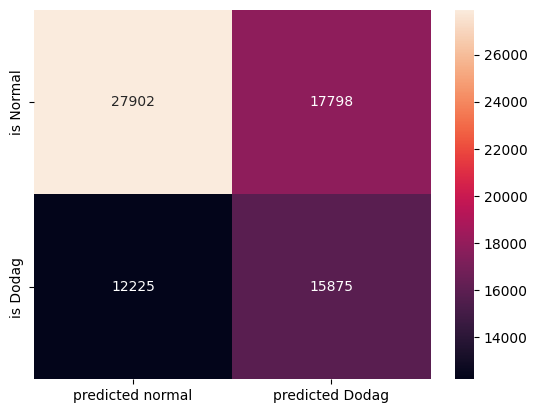

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

# Make predictions using the best model
y_predict =model_svc.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=[0, 1])

# Create DataFrame for confusion matrix
confusion = pd.DataFrame(conf_matrix, index=['is Normal', 'is Dodag'], columns=['predicted normal', 'predicted Dodag'])

# Visualize confusion matrix using heatmap
sns.heatmap(confusion, annot=True, fmt='d')

# Print classification report
print(classification_report(y_test, y_predict))


In [9]:
# Print the confusion matrix in numeric form
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
           predicted normal  predicted Dodag
is Normal             27902            17798
is Dodag              12225            15875


Correlation

In [10]:
import pandas as pd
import scipy.stats as stats

# Assuming your data is stored in a DataFrame called df
columns_of_interest = ['length', 'transmission_rate_per_1000_ms', 'reception_rate_per_1000_ms', 
                       'transmission_average_per_sec', 'reception_average_per_sec', 
                       'transmission_count_per_sec', 'reception_count_per_sec', 
                       'transmission_total_duration_per_sec', 'reception_total_duration_per_sec']

# Selecting only the numerical columns
numerical_data = df[columns_of_interest]

# Compute the Pearson correlation coefficient matrix
corr_matrix = numerical_data.corr()

# Display the correlation matrix
print(corr_matrix)


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.053865   
transmission_rate_per_1000_ms       -0.053865                       1.000000   
reception_rate_per_1000_ms          -0.138234                       0.130779   
transmission_average_per_sec        -0.008440                       0.872584   
reception_average_per_sec           -0.046488                       0.088100   
transmission_count_per_sec          -0.053854                       0.999998   
reception_count_per_sec             -0.138234                       0.130802   
transmission_total_duration_per_sec  0.067535                      -0.057986   
reception_total_duration_per_sec     0.051105                      -0.052917   

                                     reception_rate_per_1000_ms  \
length                                                -0.138234   
transmission_rate_per_1000_ms                          0.130779  

In [11]:
# Compute the Spearman correlation coefficient matrix
spearman_corr_matrix = numerical_data.corr(method='spearman')

# Display the correlation matrix
print(spearman_corr_matrix)

                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.067142   
transmission_rate_per_1000_ms       -0.067142                       1.000000   
reception_rate_per_1000_ms          -0.134497                       0.153985   
transmission_average_per_sec         0.039382                       0.163751   
reception_average_per_sec            0.019200                      -0.013096   
transmission_count_per_sec          -0.067236                       0.999994   
reception_count_per_sec             -0.134158                       0.154023   
transmission_total_duration_per_sec  0.064839                      -0.090601   
reception_total_duration_per_sec    -0.019491                       0.032755   

                                     reception_rate_per_1000_ms  \
length                                                -0.134497   
transmission_rate_per_1000_ms                          0.153985  

In [12]:

# Compute the Kendall tau correlation coefficient matrix
kendall_corr_matrix = numerical_data.corr(method='kendall')

# Display the correlation matrix
print(kendall_corr_matrix)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.052812   
transmission_rate_per_1000_ms       -0.052812                       1.000000   
reception_rate_per_1000_ms          -0.102631                       0.111481   
transmission_average_per_sec         0.029371                      -0.007054   
reception_average_per_sec            0.016180                      -0.010697   
transmission_count_per_sec          -0.052928                       0.999661   
reception_count_per_sec             -0.102351                       0.111525   
transmission_total_duration_per_sec  0.046966                      -0.062547   
reception_total_duration_per_sec    -0.015072                       0.023952   

                                     reception_rate_per_1000_ms  \
length                                                -0.102631   
transmission_rate_per_1000_ms                          0.111481  

In [13]:
import numpy as np

# Compute the correlation coefficient matrix
corr_matrix = np.corrcoef(numerical_data, rowvar=False)

# Display the correlation matrix
print(corr_matrix)

[[ 1.         -0.05386453 -0.13823418 -0.00844    -0.04648802 -0.05385384
  -0.13823364  0.06753476  0.05110463]
 [-0.05386453  1.          0.1307791   0.87258412  0.08810037  0.99999782
   0.13080156 -0.05798558 -0.0529172 ]
 [-0.13823418  0.1307791   1.          0.10674577  0.88857481  0.13077283
   0.99999857  0.03983479 -0.06676529]
 [-0.00844     0.87258412  0.10674577  1.          0.10081027  0.87238581
   0.10674103  0.11943412 -0.06323175]
 [-0.04648802  0.08810037  0.88857481  0.10081027  1.          0.08806899
   0.8884522   0.05622672  0.0084633 ]
 [-0.05385384  0.99999782  0.13077283  0.87238581  0.08806899  1.
   0.13079517 -0.05802265 -0.05306346]
 [-0.13823364  0.13080156  0.99999857  0.10674103  0.8884522   0.13079517
   1.          0.03983781 -0.06676469]
 [ 0.06753476 -0.05798558  0.03983479  0.11943412  0.05622672 -0.05802265
   0.03983781  1.         -0.08698826]
 [ 0.05110463 -0.0529172  -0.06676529 -0.06323175  0.0084633  -0.05306346
  -0.06676469 -0.08698826  1. 

In [14]:
import pandas as pd
corr_coefficient = df['length'].corr(df['transmission_rate_per_1000_ms'])
print("Correlation coefficient between column1 and column2:", corr_coefficient)


Correlation coefficient between column1 and column2: -0.0538645261031402


In [15]:
spearman_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='spearman')

kendall_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='kendall')

print("Spearman correlation coefficient:", spearman_corr)
print("Kendall correlation coefficient:", kendall_corr)

Spearman correlation coefficient: -0.06714188676565222
Kendall correlation coefficient: -0.05281197229128233


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [16]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

print(correlation_matrix)


                                         time    source  destination  \
time                                 1.000000  0.037697    -0.091269   
source                               0.037697  1.000000    -0.023759   
destination                         -0.091269 -0.023759     1.000000   
length                               0.208842  0.000595     0.048047   
info                                -0.106453 -0.000376     0.942440   
transmission_rate_per_1000_ms       -0.253624 -0.314914     0.020550   
reception_rate_per_1000_ms          -0.154010 -0.011052    -0.169080   
transmission_average_per_sec        -0.120800 -0.121407    -0.032993   
reception_average_per_sec           -0.038937 -0.010967    -0.118551   
transmission_count_per_sec          -0.253704 -0.315090     0.020598   
reception_count_per_sec             -0.154125 -0.011049    -0.169185   
transmission_total_duration_per_sec  0.164753  0.073738    -0.166053   
reception_total_duration_per_sec    -0.073529 -0.018722     0.69

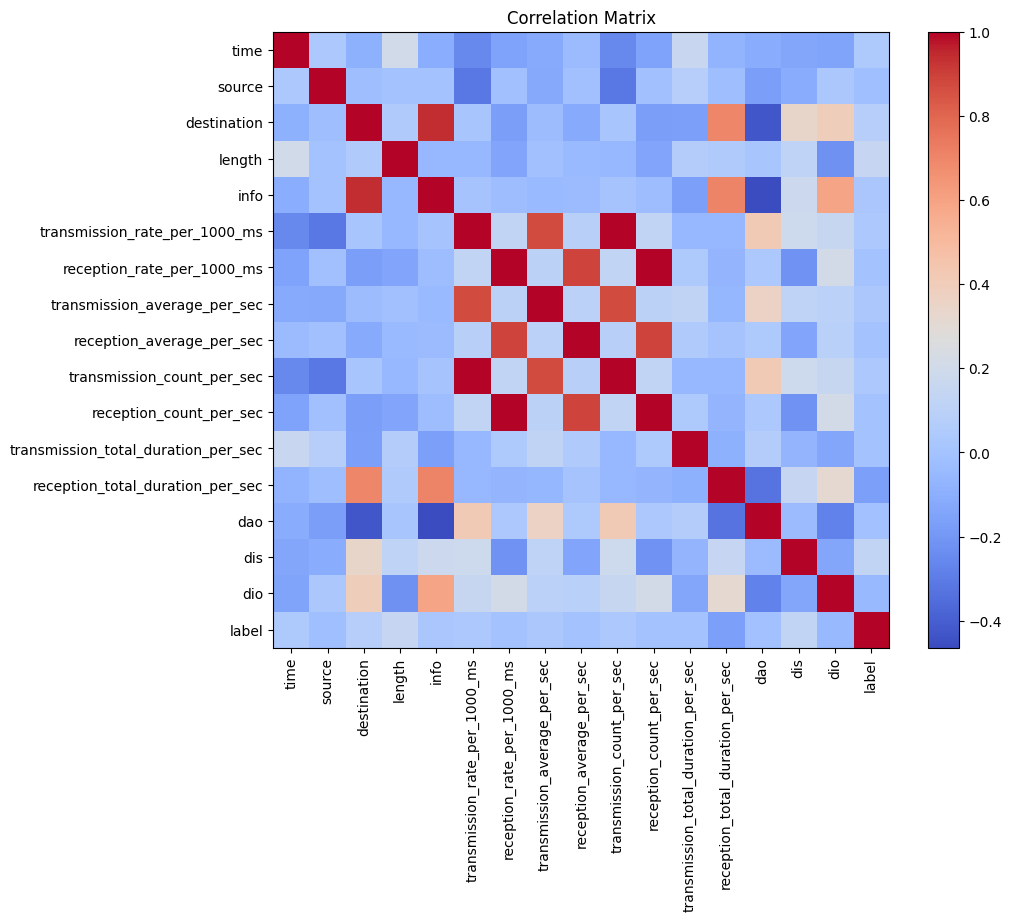

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()
